In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Essential functions

In [ ]:
#prints unique values and their frequencies
def unique_vals(data):
  val, ct = np.unique(data, return_counts=True)
  print(str(val) + "\n" + str(ct))
  # print("tree/all: " + str(round(ct[1] / ct[0] * 100, 2)) + "%")

In [ ]:
import os
import cv2
import numpy as np
#function to crop an image
def crop_image_and_mask(image_path='', mask_path='', height=128, width=128):
    # Create lists to store cropped images and masks
    cropped_images = []
    cropped_masks = []

    image = cv2.imread(image_path) #bgr image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    # Crop the image and mask to the specified size
    img_width = image.shape[1]
    img_height = image.shape[0]
    for i in range(0, img_height, height):
        for j in range(0, img_width, width):
            cropped_image = image[i:min(i+height, img_height), j:min(j+width, img_width)]
            cropped_mask = mask[i:min(i+height, img_height), j:min(j+width, img_width)]
            # Ensure the cropped image and mask have the correct size
            if cropped_image.shape[:2] == (height, width) and cropped_mask.shape == (height, width):
                # Convert the binary mask to 0 and 1
                # cropped_mask [cropped_mask == 255] = 1

                # Append the cropped image and mask to the lists
                cropped_images.append(cropped_image)
                cropped_masks.append(cropped_mask)

            else:
                padded_img = np.zeros((height, width, 3), dtype=cropped_images[-1].dtype)
                padded_mask = np.zeros((height, width), dtype=cropped_masks[-1].dtype)
                padded_img[:cropped_image.shape[0], :cropped_image.shape[1], :] = cropped_image
                padded_mask[:cropped_mask.shape[0], :cropped_mask.shape[1]] = cropped_mask
                # Append the cropped image and mask to the lists
                cropped_images.append(padded_img)
                cropped_masks.append(padded_mask)

    # Convert lists to NumPy arrays
    cropped_images_array = np.array(cropped_images)
    cropped_masks_array = np.array(cropped_masks)
    cropped_masks_array[cropped_masks_array==255]=1
    return (cropped_images_array, cropped_masks_array)

In [ ]:
import os
def save_model(model, model_name, folder_path):
  file_path = os.path.join(folder_path, model_name + '.h5')
  if os.path.exists(file_path):
    # If it exists, remove the file
    os.remove(file_path)
  model.save(file_path)

In [ ]:
#merge patches
import numpy as np
import cv2
import matplotlib.pyplot as plt

def merge(patches, mask_path, patch_size):
  mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
  img = np.zeros_like(mask)

  height = patch_size[0]
  width = patch_size[1]

  img_height = mask.shape[0]
  img_width = mask.shape[1]
  ct = 0
  for i in range(0, img_height, height):
    for j in range(0, img_width, width):
      img[i:min(i+height, img_height), j:min(j+width, img_width)] = patches[ct, : min(i+height, img_height)-i, : min(j+width, img_width)-j]
      # unique_vals(img[i:min(i+height, img_height), j:min(j+width, img_width)])
      ct += 1

  return img

In [ ]:
def adjust_pred(prediction, threshold):
  shape = prediction.shape
  pred = prediction.copy().reshape(shape[:-1])
  y_pred = pred
  y_pred[y_pred >= threshold] = 255
  y_pred[y_pred < threshold] = 0
  return y_pred


In [ ]:
def save_prediction(binary_image, file_path):
    # Check if the file already exists
    if os.path.exists(file_path):
      # Remove the existing file
      os.remove(file_path)

    # Save the binary image
    cv2.imwrite(file_path, binary_image)

In [ ]:
import numpy as np

def calculate_iou(ground_truth, prediction):
    # Flatten the arrays to 1D
    ground_truth_flat = ground_truth.flatten()
    prediction_flat = prediction.flatten()

    # Calculate the intersection and union
    intersection = np.sum(np.logical_and(ground_truth_flat, prediction_flat))
    union = np.sum(np.logical_or(ground_truth_flat, prediction_flat))

    # Calculate IoU
    iou = intersection / union if union != 0 else 0.0

    return iou



In [ ]:
def adjust_data(X_test, y_test):
  y_test = y_test.astype(np.float32)
  X_test = X_test.astype(np.float32)
  X_test = X_test/255.0

  return (X_test, y_test)

# Models


In [ ]:
#U-net
import numpy as np
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras


def unet(input_size=(128,128,3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, (1,1), activation = 'sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    model.compile(optimizer = Adam(learning_rate = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    # model.compile(optimizer = Adam(learning_rate = 1e-4), loss = dice_loss, metrics = ['accuracy'])


    #model.summary()

    return model



# Train model with each image


In [ ]:
files = ['kho_xang_h6.tif', 'vinaconex.tif', 'vd34.tif', 'vd5.tif', 'chua_kham_son.tif', 'sun_hoabinh_sangolf.tif', 'sun_hoabinh_doithung.tif', 'vd2.tif', 'vd1.tif', 'sun_hoabinh_cuoiha.tif']

Train unet with each image

In [ ]:
import numpy as np
unet_model = unet((256,256,3))


train_image = "/content/drive/MyDrive/GR2/Dataset/Train/Image"
train_mask = "/content/drive/MyDrive/GR2/Dataset/Train/Mask"

test_image = "/content/drive/MyDrive/GR2/Dataset/Test/Image"
test_mask = "/content/drive/MyDrive/GR2/Dataset/Test/Mask"

histories = []

for file_name in files:
    print("Reading image: " + file_name)
    file_name_without_extension = os.path.splitext(os.path.basename(file_name))[0]
    X_train = np.load(os.path.join(train_image, file_name_without_extension + '.npy'))
    y_train = np.load(os.path.join(train_mask, file_name_without_extension + '.npy'))
    history = unet_model.fit(X_train, y_train, epochs=25, batch_size=16)
    histories.append(history)
#     X_train_list.append(imgs)
#     y_train_list.append(masks)

# X_train = np.concatenate(X_train_list, axis=0)
# y_train = np.concatenate(y_train_list, axis=0)

# history = unet_model.fit(X_train, y_train, epochs=100, batch_size=64)

output_dir = '/content/drive/MyDrive/GR2/Model/'
unet_model.save(output_dir + 'unet_model_rgb_256x256.h5')

In [ ]:
import os
os.listdir('/content/drive/MyDrive/GR2/Model')

['unet-model.h5',
 'unet-model2.h5',
 'unet_rgb.h5',
 'unet_rgb_64.h5',
 'unet_choromatic_rgb.h5',
 'unet_chromatic_128_6b_new.h5',
 'unet_chromatic_128_6b.h5',
 'unet_model_rgb_256x256.h5']

In [ ]:
model_history = np.array(histories)
file_path_to_save = '/content/drive/MyDrive/GR2/Model/unet_model_rgb_256x256_history.npy'
if os.path.exists(file_path_to_save):
  os.remove(file_path_to_save)
np.save(file_path_to_save, model_history)

In [ ]:
import numpy as np
histories = np.load('/content/drive/MyDrive/GR2/Model/unet_model_rgb_256x256_history.npy', allow_pickle=True)


In [ ]:
n = len(histories[0].history['loss'])
acc = [0] * n
loss = [0] * n
for i in range(len(histories)):
  for j in range(n):
    acc[j] += histories[i].history['accuracy'][j]
    loss[j] += histories[i].history['loss'][j]

for i in range(n):
  acc[i] /= len(histories)
  loss[i] /= len(histories)

print(acc)
print(loss)

[0.9320820987224578, 0.939790952205658, 0.9456587553024292, 0.949083149433136, 0.9519231259822846, 0.954329377412796, 0.9549186050891876, 0.9542059481143952, 0.9560594677925109, 0.9569762408733368, 0.9569607615470886, 0.9570637941360474, 0.9590739011764526, 0.9610585689544677, 0.9608981668949127, 0.9628872513771057, 0.9634201407432557, 0.9629914879798889, 0.9641429662704468, 0.9645918667316437, 0.965194433927536, 0.9638541281223297, 0.9692691385746002, 0.9689302623271943, 0.9722964704036713]
[0.25073421448469163, 0.2328812934458256, 0.22003402635455133, 0.20017224550247192, 0.1940154530107975, 0.18870441243052483, 0.18655288442969323, 0.1878634698688984, 0.18453641459345818, 0.18320846036076546, 0.1849625214934349, 0.1814873270690441, 0.1783606640994549, 0.1756919652223587, 0.17437264323234558, 0.17160532101988793, 0.16986674666404725, 0.1703944757580757, 0.167499078810215, 0.1665666349232197, 0.16555254012346268, 0.16791578158736228, 0.16486506536602974, 0.1640211559832096, 0.16077141

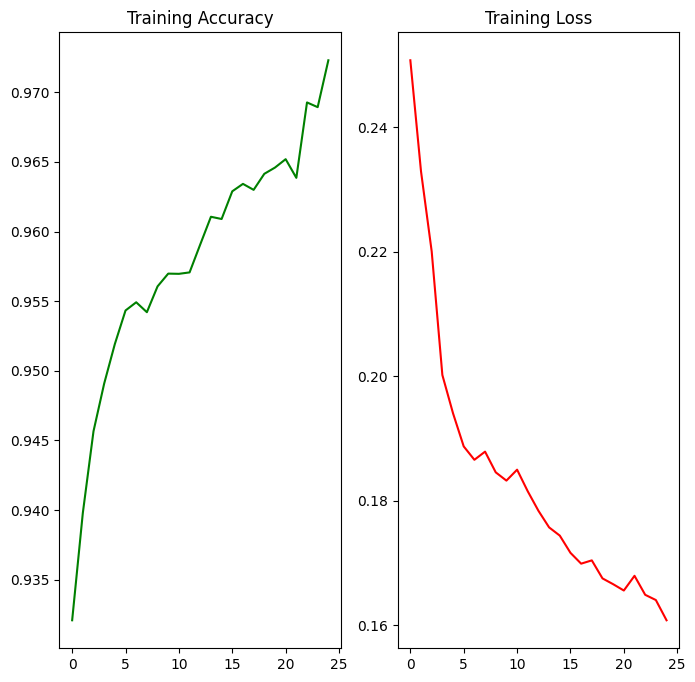

In [ ]:
import matplotlib.pyplot as plt

epochs_range = range(n)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', color='green')
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', color='red')
# plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

# Evaluate Model

In [3]:
from tensorflow.keras.models import load_model
unet_model = load_model('/content/drive/MyDrive/GR2/Model/unet_model_rgb_256x256.h5')

In [5]:
import numpy as np
import os
files = ['kho_xang_h6.tif', 'vinaconex.tif', 'vd34.tif', 'vd5.tif', 'chua_kham_son.tif', 'sun_hoabinh_sangolf.tif', 'sun_hoabinh_doithung.tif', 'vd2.tif', 'vd1.tif', 'sun_hoabinh_cuoiha.tif']

test_image = "/content/drive/MyDrive/GR2/Dataset/Test/Image"
test_mask = "/content/drive/MyDrive/GR2/Dataset/Test/Mask"

X_test_list = []
y_test_list= []
for file_name in files:
    print("Reading image: " + file_name)
    file_name_without_extension = os.path.splitext(os.path.basename(file_name))[0]
    imgs = np.load(os.path.join(test_image, file_name_without_extension + '.npy'))
    masks = np.load(os.path.join(test_mask, file_name_without_extension + '.npy'))
    X_test_list.append(imgs)
    y_test_list.append(masks)

X_test = np.concatenate(X_test_list, axis=0)
y_test = np.concatenate(y_test_list, axis=0)

Reading image: kho_xang_h6.tif
Reading image: vinaconex.tif
Reading image: vd34.tif
Reading image: vd5.tif
Reading image: chua_kham_son.tif
Reading image: sun_hoabinh_sangolf.tif
Reading image: sun_hoabinh_doithung.tif
Reading image: vd2.tif
Reading image: vd1.tif
Reading image: sun_hoabinh_cuoiha.tif


In [6]:
test_loss, test_accuracy = unet_model.evaluate(X_test, y_test)

55/55 [==============================] - 63s 707ms/step - loss: 0.6302 - accuracy: 0.8947


In [7]:
print(f'Test Accuracy: {test_accuracy*100:.2f}%, Test Loss: {test_loss:.2f}')


Test Accuracy: 89.47%, Test Loss: 0.63


# Predict And Infer Images

In [ ]:
import cv2

image_folder = "/content/drive/MyDrive/GR2/Scene"
mask_folder = "/content/drive/MyDrive/GR2/Mask"
infered_img_folder = '/content/drive/MyDrive/GR2/InferredImage'

IOU_list = []

files = ['kho_xang_h6.tif', 'vinaconex.tif', 'vd34.tif', 'vd5.tif', 'chua_kham_son.tif', 'sun_hoabinh_sangolf.tif', 'sun_hoabinh_doithung.tif', 'vd2.tif', 'vd1.tif', 'sun_hoabinh_cuoiha.tif']
for file_name in files:
  image_path = os.path.join(image_folder, file_name)
  mask_path = os.path.join(mask_folder, file_name)

  X_test, y_test = crop_image_and_mask(image_path, mask_path, 256, 256)
  X_test, y_test = adjust_data(X_test, y_test)

  prediction = unet_model.predict(X_test)
  y_pred = adjust_pred(prediction, 0.5)
  img = merge(y_pred, mask_path, (256,256))
  #save infered image
  infered_img_path = os.path.join(infered_img_folder, file_name)
  print(infered_img_path)
  save_prediction(img, infered_img_path)
  #calculate IOU
  mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
  iou = calculate_iou(mask, img)
  IOU_list.append({file_name : iou})




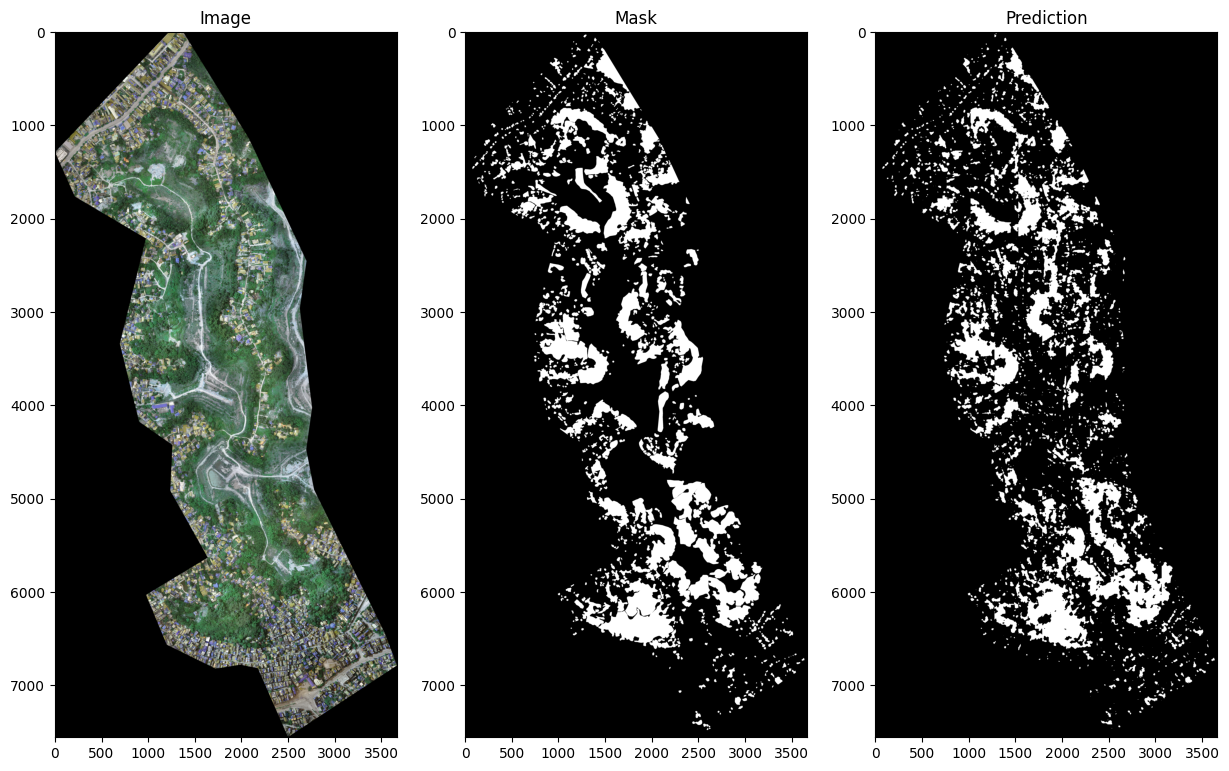

In [ ]:
#show inferred image
import cv2
import matplotlib.pyplot as plt
import os

image_folder = "/content/drive/MyDrive/GR2/Scene"
path = '/content/drive/MyDrive/GR2/InferredImage'
mask_folder = "/content/drive/MyDrive/GR2/Mask"

plt.figure(figsize=(15, 15))

img_paths = os.listdir(path)

img = cv2.imread(os.path.join(image_folder, img_paths[9]))
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title("Image")

img = cv2.imread(os.path.join(mask_folder, img_paths[9]), cv2.IMREAD_GRAYSCALE)
plt.subplot(1, 3, 2)
plt.imshow(img, cmap='gray')
plt.title("Mask")

img = cv2.imread(os.path.join(path, img_paths[9]), cv2.IMREAD_GRAYSCALE)
plt.subplot(1, 3, 3)
plt.imshow(img, cmap='gray')
plt.title("Prediction")

plt.show()

